In [48]:
import xarray as xr
import pandas as pd
import numpy as np
#import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sn

from glob import glob
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from imblearn.over_sampling import SMOTE

from tqdm import tqdm

In [49]:
ds_p = xr.open_dataset("/data-uerra/mescan-surfex/precipitation/mescan-surfex-nordics-precipitation_ymon.nc")

In [50]:
ds_t_avg = xr.open_dataset("/data-uerra/mescan-surfex/temperature/mescan-surfex-nordics-temperature-ymon.nc")

In [51]:
ds_t_std = xr.open_dataset("/data-uerra/mescan-surfex/temperature/mescan-surfex-nordics-t2m_ymonstd.nc")

In [52]:
lons, lats = np.meshgrid(ds_p.lon, ds_p.lat)

In [53]:
ds_pine = xr.open_dataset('../../data/finland/mescan_surfex_pine_ratio_finland.nc')

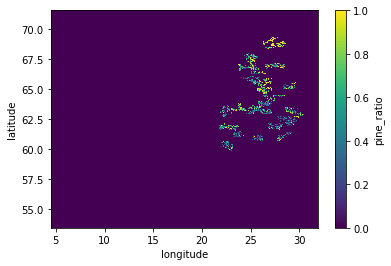

In [54]:
ds_pine.pine_ratio.plot()

In [55]:
data = {
    'ratio': ds_pine.pine_ratio.values.ravel()
}

In [56]:
for m in range(0, 12):
    data["p%02d" % (m + 1)] = ds_p.tp[m,:,:].values.ravel()
    data["tavg%02d" % (m + 1)] = ds_t_avg['2t'][m,:,:].values.ravel()
    data["tstd%02d" % (m + 1)] = ds_t_std['2t'][m,:,:].values.ravel()

In [57]:
df = pd.DataFrame(data)

In [58]:
df.dropna(inplace=True)

In [59]:
df['predominant'] = np.where(df['ratio'] > 0.5, 1, 0)

In [60]:
df.head()

,ratio,p01,tavg01,tstd01,p02,tavg02,tstd02,p03,tavg03,tstd03,...,p10,tavg10,tstd10,p11,tavg11,tstd11,p12,tavg12,tstd12,predominant
0,0.0,1028.032227,5.608397,7.007261,917.894836,5.002995,7.260077,650.246582,5.655244,6.870195,...,1568.007690,13.477379,6.853115,1500.251465,10.144375,6.999880,1369.432983,6.964911,7.071146,0
1,0.0,1030.239990,5.552064,7.020378,918.201050,4.964746,7.266491,655.511414,5.644968,6.875551,...,1570.813110,13.457698,6.857547,1527.257690,10.099838,7.006363,1403.411987,6.912345,7.084951,0
2,0.0,1016.340820,5.489423,7.035015,906.867371,4.926759,7.274645,654.641479,5.643862,6.882475,...,1567.075073,13.434568,6.862309,1534.351562,10.043708,7.013369,1418.747681,6.846510,7.099665,0
3,0.0,1007.638123,5.422871,7.050332,899.044739,4.887269,7.282977,658.758667,5.644159,6.890760,...,1578.622925,13.406312,6.867037,1547.973633,9.977019,7.020970,1435.245117,6.770231,7.115871,0
4,0.0,1009.436646,5.354242,7.066104,896.284363,4.846446,7.290096,667.336914,5.641715,6.899733,...,1600.710693,13.374018,6.871669,1566.086426,9.903564,7.029491,1456.438599,6.687763,7.133628,0


In [61]:
df.columns[1:-1]

Index(['p01', 'tavg01', 'tstd01', 'p02', 'tavg02', 'tstd02', 'p03', 'tavg03',
       'tstd03', 'p04', 'tavg04', 'tstd04', 'p05', 'tavg05', 'tstd05', 'p06',
       'tavg06', 'tstd06', 'p07', 'tavg07', 'tstd07', 'p08', 'tavg08',
       'tstd08', 'p09', 'tavg09', 'tstd09', 'p10', 'tavg10', 'tstd10', 'p11',
       'tavg11', 'tstd11', 'p12', 'tavg12', 'tstd12'],
      dtype='object')

In [62]:
X = df[df.columns[1:-1]]

In [63]:
y = df["predominant"]

In [64]:
X_resampled, y_resampled = SMOTE().fit_resample(X, y)

In [65]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled)

In [66]:
rf = RandomForestClassifier(n_estimators=200, max_depth=6)

In [67]:
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=6, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [68]:
y_pred = rf.predict(X_test)

In [69]:
precision_score(y_test, y_pred)

0.8781212841854935

In [70]:
accuracy_score(y_test, y_pred)

0.9307596176579863

In [75]:
recall_score(y_test, y_pred)

1.0

In [72]:
cm = confusion_matrix(y_test, y_pred)
cm

array([[25574,  4100],
       [    0, 29540]])

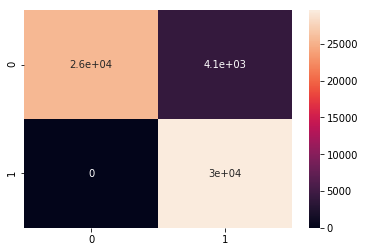

In [74]:
sn.heatmap(cm, annot=True)

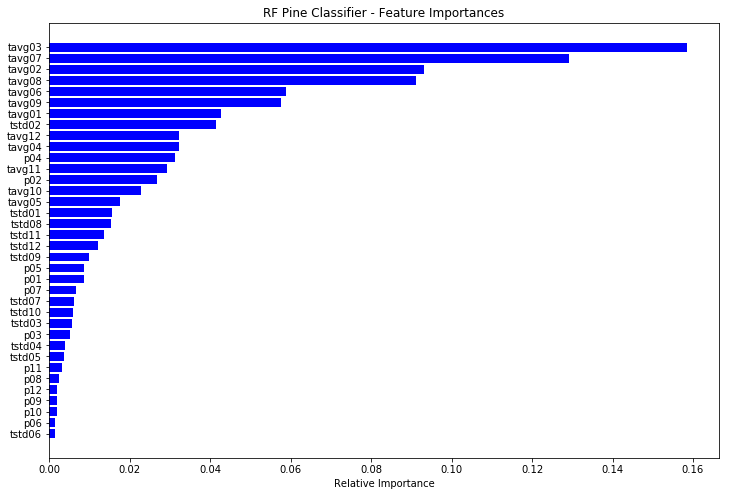

In [82]:
features = [c for c in X.columns]
importances = rf.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(12,8))
plt.title('RF Pine Classifier - Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()